In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import sys
sys.path.append('..')
import ca2_mec.project_path
import expipe_plugin_cinpla
from expipe_plugin_cinpla.tools.trackunitmulticomparison import TrackMultipleSessions
import expipe_plugin_cinpla.tools.data_processing as dp
from expipe_plugin_cinpla.tools.registration import store_notebook
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import quantities as pq
from distutils.dir_util import copy_tree
from datetime import timedelta
from tqdm import tqdm_notebook as tqdm
import networkx as nx
#from nxpd import draw
%matplotlib inline

In [3]:
project_path = ca2_mec.project_path.project_path()
project = expipe.get_project(project_path)
actions = project.actions

identify_neurons = project.require_action('identify-neurons')
data_loader = dp.Data(project)

In [4]:
#include = ['013-050521-1', '013-050521-2', '013-050521-3', '013-050521-4', '013-050521-5']
include = ['001-181220-2', '001-181220-3', '001-181220-4', '001-181220-5', '001-181220-6', 
        '001-191220-1', '001-191220-3', '001-191220-6', '001-191220-7', '001-191220-8']
#include = ['001-211220-1', '001-211220-2', '001-211220-3', '001-211220-4', '001-211220-5',
#         '001-221220-1', '001-221220-2', '001-221220-3', '001-221220-4', '001-221220-5']
#include = ['001-280721-1', '001-280721-2', '001-280721-3', '001-280721-4', '001-280721-5'] #Maria sine opptak fra MEC
#include = ['002-050721-1', '002-050721-2', '002-050721-3', '002-050721-4', '002-050721-5'] #Maria sine opptak fra MEC
#include = ['001-140721-2', '001-140721-3', '001-140721-4', '001-140721-5', '001-140721-6', '001-140721-7'] #Maria, novel


#include = ['013-050521-1', '013-050521-2', '013-050521-3', '013-050521-4', '013-050521-5']
#include = ['011-120321-2', '011-120321-3', '011-120321-4', '011-120321-5', '011-120321-6']
#include = ['022-160322-1', '022-160322-2', '022-160322-3', '022-160322-4', '022-160322-5', '022-160322-7']
#include = ['007-081221-1','007-081221-2','007-081221-3', '007-081221-4','007-081221-5','007-081221-6']

# find the complement of include
skip_actions = []
for action in actions:
    if action not in include:
        skip_actions.append(action)
skip_actions, include

(['identify-neurons'],
 ['001-181220-2',
  '001-181220-3',
  '001-181220-4',
  '001-181220-5',
  '001-181220-6',
  '001-191220-1',
  '001-191220-3',
  '001-191220-6',
  '001-191220-7',
  '001-191220-8'])

In [5]:
sessions = []
for action in actions.values():
    if action.id in skip_actions:
        continue
    if action.type != 'Recording':
        continue
    print(action.id)
    action_data_path = dp.get_data_path(action)

    sessions.append({
       'action': action.id,
       'session': int(action.id.split('-')[-1]),
       'entity': action.entities[0],

   })
sessions = pd.DataFrame(sessions)

001-191220-6
001-191220-3
001-191220-8
001-181220-3
001-181220-5
001-191220-7
001-181220-6
001-181220-2
001-191220-1
001-181220-4


In [6]:
sessions['date'] = sessions.apply(lambda x: x.action.split('-')[1], axis=1)
sessions['entity_date'] = sessions.apply(lambda x: '-'.join(x.action.split('-')[:2]), axis=1)
sessions.to_csv(identify_neurons.data_path() / 'sessions.csv', index=False)
sessions

,action,session,entity,date,entity_date
0,001-191220-6,6,001,191220,001-191220
1,001-191220-3,3,001,191220,001-191220
2,001-191220-8,8,001,191220,001-191220
3,001-181220-3,3,001,181220,001-181220
4,001-181220-5,5,001,181220,001-181220
5,001-191220-7,7,001,191220,001-191220
6,001-181220-6,6,001,181220,001-181220
7,001-181220-2,2,001,181220,001-181220
8,001-191220-1,1,001,191220,001-191220
9,001-181220-4,4,001,181220,001-181220


# Identify unique neurons

In [7]:
sessions_include = sessions
sessions_include

#sessions_include = sessions.query("action.isin(@immutable_include)")


#Older option for this cell:
#sessions_include = sessions.query("action.isin(@include)")
#sessions_include


,action,session,entity,date,entity_date
0,001-191220-6,6,001,191220,001-191220
1,001-191220-3,3,001,191220,001-191220
2,001-191220-8,8,001,191220,001-191220
3,001-181220-3,3,001,181220,001-181220
4,001-181220-5,5,001,181220,001-181220
5,001-191220-7,7,001,191220,001-191220
6,001-181220-6,6,001,181220,001-181220
7,001-181220-2,2,001,181220,001-181220
8,001-191220-1,1,001,191220,001-191220
9,001-181220-4,4,001,181220,001-181220


In [8]:
# save graphs
for entity, values in sessions_include.groupby('entity'):
    print(entity, values)
    data_path = identify_neurons.data_path() / f'{entity}-graphs'
    if data_path.exists():
        shutil.rmtree(data_path)
#         continue
    unit_matching = TrackMultipleSessions(
        actions, action_list=values.action.values.tolist(), 
        progress_bar=tqdm, verbose=False, data_path=data_path
    )
    unit_matching.do_matching()
    unit_matching.make_graphs_from_matches()     
    unit_matching.compute_time_delta_edges()
    unit_matching.compute_depth_delta_edges()
    # save graph with all dissimilarities for later use
    unit_matching.save_graphs()

001          action  session entity    date entity_date
0  001-191220-6        6    001  191220  001-191220
1  001-191220-3        3    001  191220  001-191220
2  001-191220-8        8    001  191220  001-191220
3  001-181220-3        3    001  181220  001-181220
4  001-181220-5        5    001  181220  001-181220
5  001-191220-7        7    001  191220  001-191220
6  001-181220-6        6    001  181220  001-181220
7  001-181220-2        2    001  181220  001-181220
8  001-191220-1        1    001  191220  001-191220
9  001-181220-4        4    001  181220  001-181220


  0%|          | 0/45 [00:00<?, ?it/s]

# Plot comparisons

In [13]:
entity = "001"
max_dissimilarity = 0.06 #default is 0.05
max_depth_delta = 100

unit_comp = TrackMultipleSessions(
    actions, sessions_include.action.values, data_path=identify_neurons.data_path() / f'{entity}-graphs')

unit_comp.load_graphs()

unit_comp.remove_edges_above_threshold('weight', max_dissimilarity)
unit_comp.remove_edges_above_threshold('depth_delta', max_depth_delta)

unit_comp.remove_edges_with_duplicate_actions()
unit_comp.identify_units()

Zero units found on channel group tetrode5
Zero units found on channel group tetrode4
Zero units found on channel group tetrode6
Zero units found on channel group tetrode7


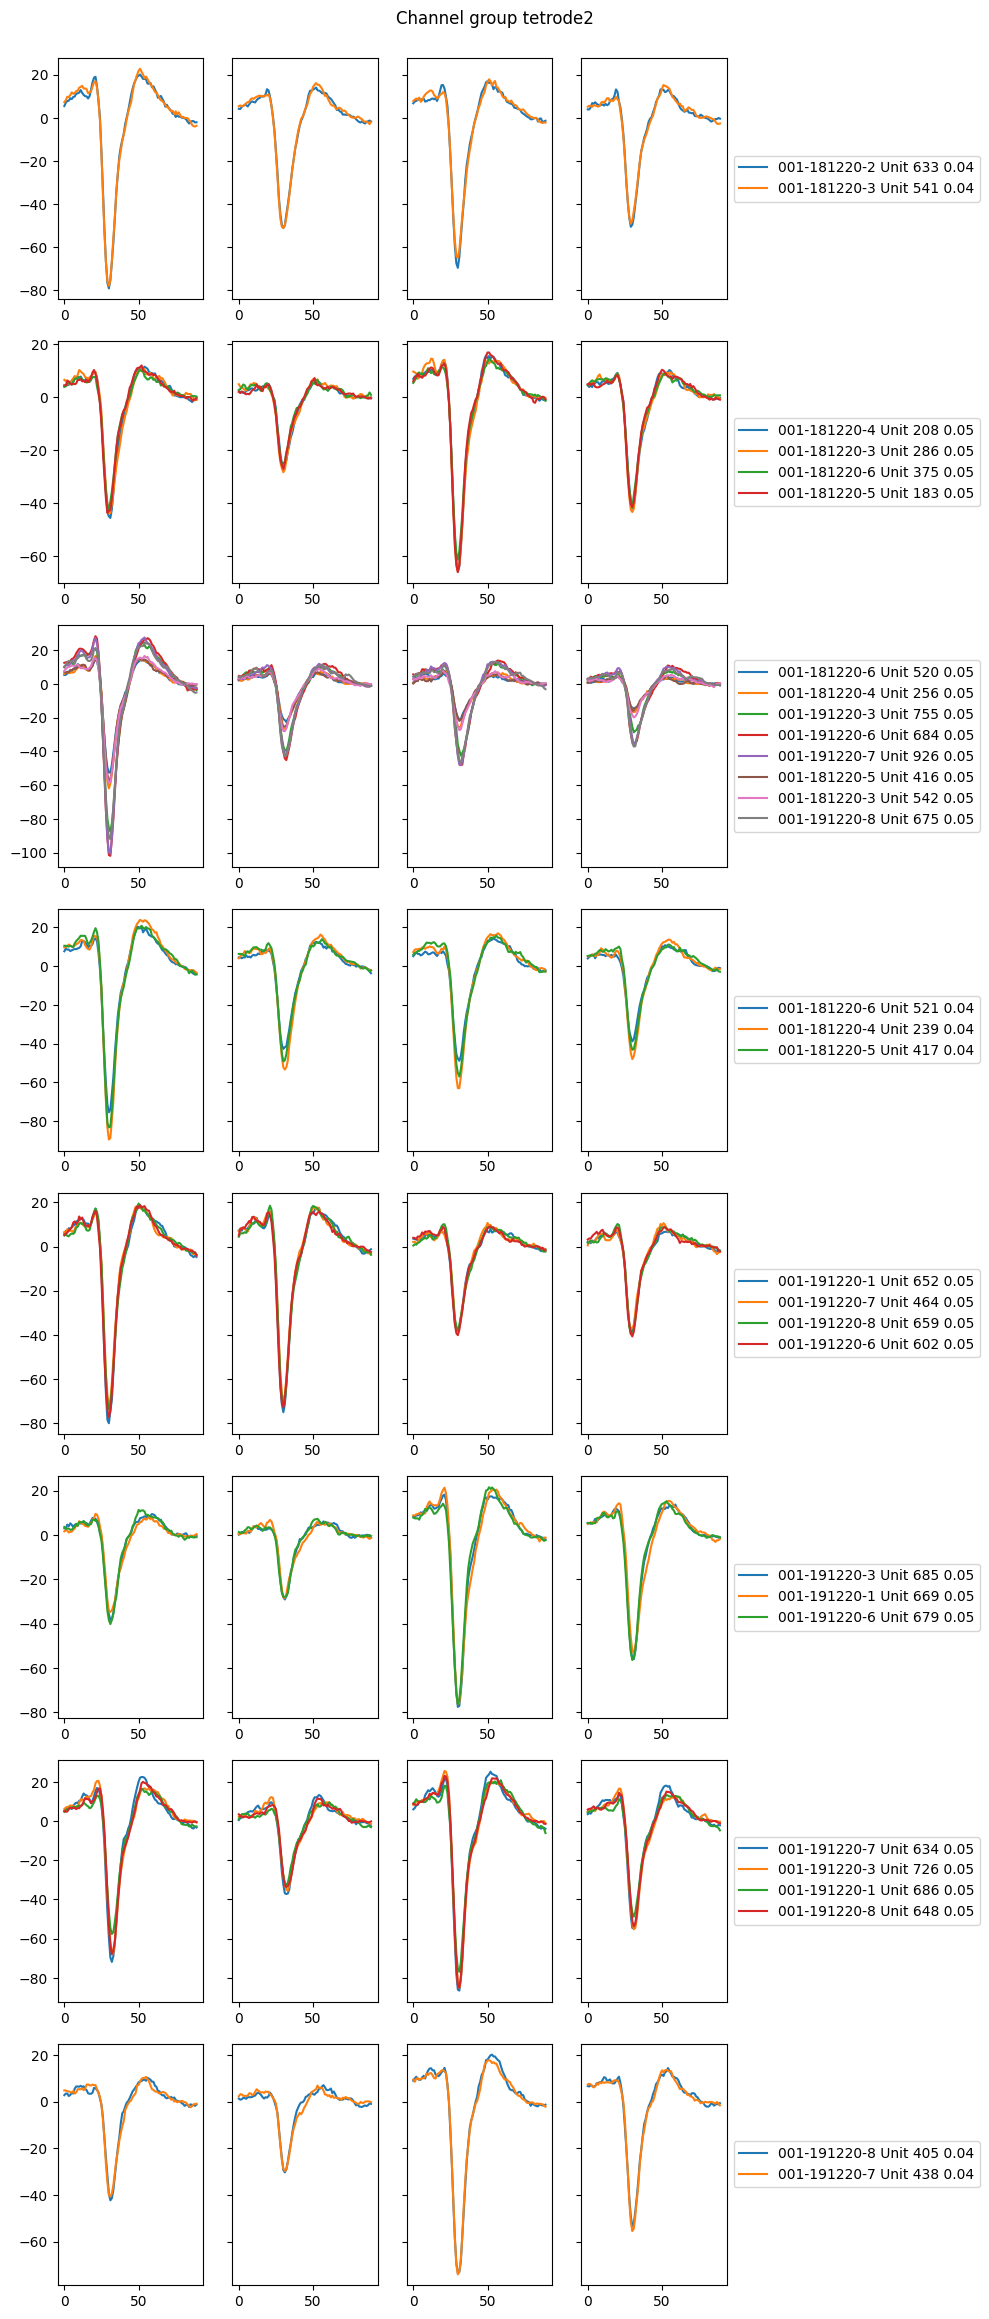

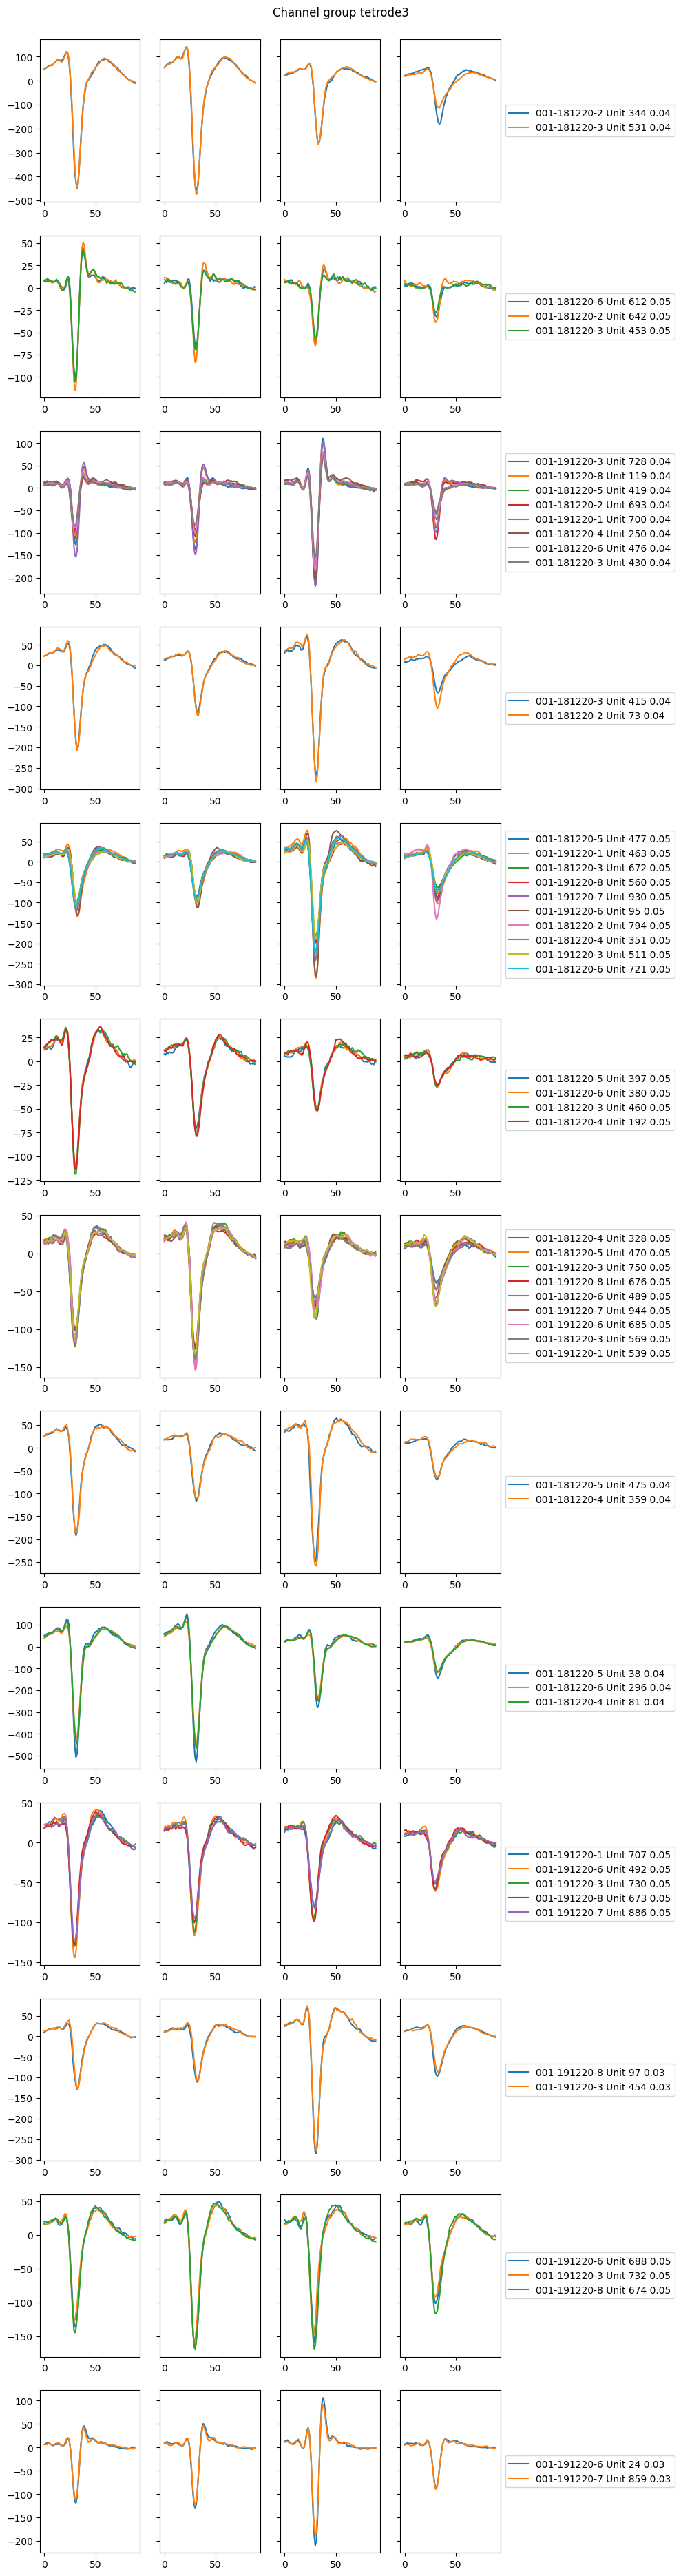

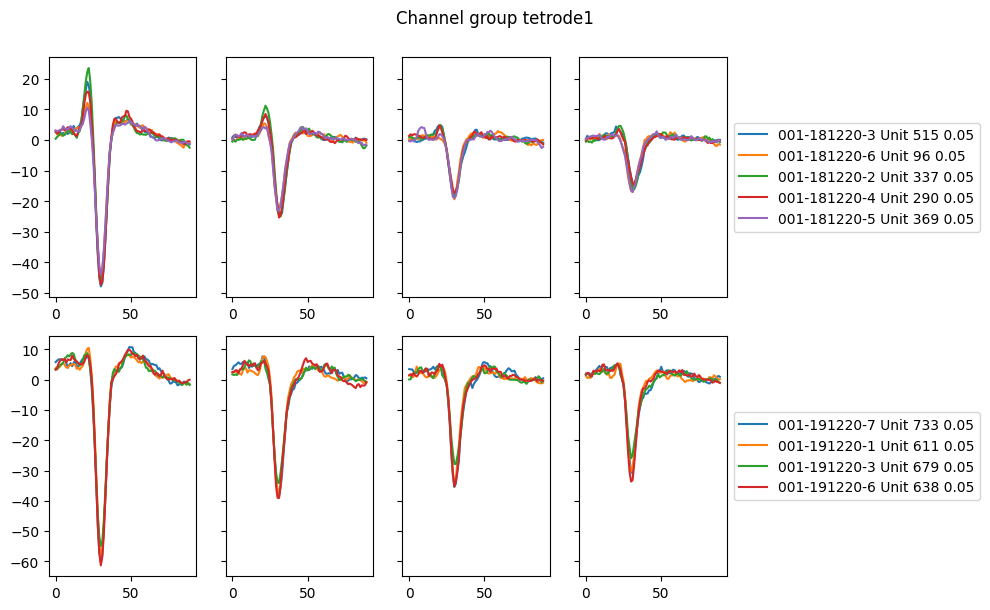

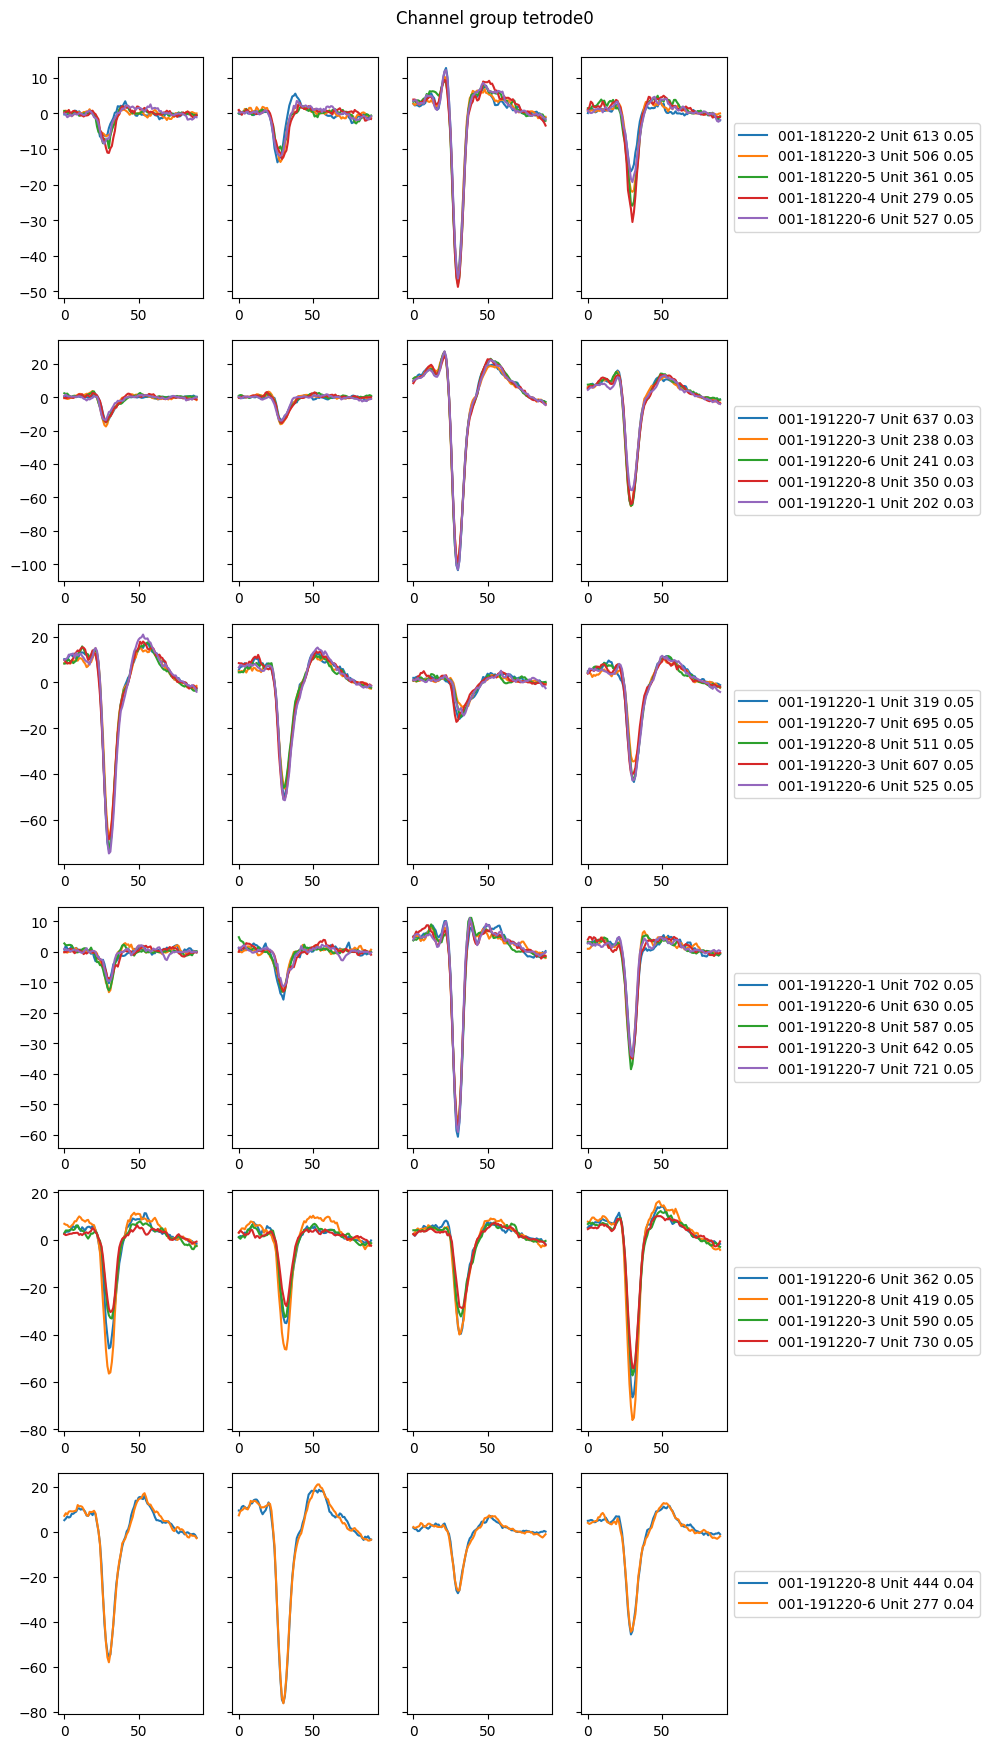

In [14]:
#unit_comp.plot_matches(chan_group='tetrode1', step_color=False)
unit_comp.plot_matches(step_color=False)

#plt.tight_layout()

# Store uniqe unit ids to csv

In [15]:
id_nums = {}
num = 0
output = identify_neurons.data_path()

for entity, values in sessions_include.groupby('entity'):
    data_path = output / f'{entity}-graphs'
    unit_matching = TrackMultipleSessions(
        actions, values.action.values.tolist(), 
        progress_bar=tqdm, verbose=False, data_path=data_path
    )
    unit_matching.load_graphs()
    # cutoff large dissimilarities
    unit_matching.remove_edges_above_threshold('weight', max_dissimilarity)
    unit_matching.remove_edges_above_threshold('depth_delta', max_depth_delta)
    unit_matching.remove_edges_with_duplicate_actions()
    unit_matching.identify_units()
    units = []
    for ch, group in unit_matching.identified_units.items():
        for unit_id, val in group.items():
            for action_id, orig_unit_ids in val['original_unit_ids'].items():
                if unit_id not in id_nums:
                    id_nums[unit_id] = num
                    num += 1
                units.extend([
                    {
                        'unit_name': name, 
                        'unit_idnum': id_nums[unit_id],
                        'unit_id': unit_id, 
                        'action': action_id,
                        'channel_group': ch,
                        'max_dissimilarity': max_dissimilarity,
                        'max_depth_delta': max_depth_delta
                    } 
                    for name in orig_unit_ids])
    units = pd.DataFrame(units)
    units = units[~units.action.isin(skip_actions)]
    units.to_csv(output / f'{entity}-units.csv', index=False)

In [16]:
unique_units = pd.concat([
    pd.read_csv(p) 
    for p in output.iterdir() 
    if p.name.endswith('-units.csv')])

In [17]:
unique_units.to_csv(output / 'units.csv', index=False)

# Store results in Expipe action

In [18]:
identify_neurons.data['sessions'] = 'sessions.csv'
identify_neurons.data['units'] = 'units.csv'

In [19]:
copy_tree(output, str(identify_neurons.data_path()))

['/projects/ec109/Sarah/projects/hpc-social-nwb/actions/identify-neurons/data/sessions.csv',
 '/projects/ec109/Sarah/projects/hpc-social-nwb/actions/identify-neurons/data/00-identify-neurons.ipynb',
 '/projects/ec109/Sarah/projects/hpc-social-nwb/actions/identify-neurons/data/001-graphs/graph-group-tetrode2.yaml',
 '/projects/ec109/Sarah/projects/hpc-social-nwb/actions/identify-neurons/data/001-graphs/graph-group-tetrode5.yaml',
 '/projects/ec109/Sarah/projects/hpc-social-nwb/actions/identify-neurons/data/001-graphs/graph-group-tetrode3.yaml',
 '/projects/ec109/Sarah/projects/hpc-social-nwb/actions/identify-neurons/data/001-graphs/graph-group-tetrode4.yaml',
 '/projects/ec109/Sarah/projects/hpc-social-nwb/actions/identify-neurons/data/001-graphs/graph-group-tetrode1.yaml',
 '/projects/ec109/Sarah/projects/hpc-social-nwb/actions/identify-neurons/data/001-graphs/graph-group-tetrode0.yaml',
 '/projects/ec109/Sarah/projects/hpc-social-nwb/actions/identify-neurons/data/001-graphs/graph-grou

In [20]:
store_notebook(
    identify_neurons, "00-identify-neurons.ipynb")

[NbConvertApp] Converting notebook 00-identify-neurons.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 2325807 bytes to 00-identify-neurons.html


## Load and view results

In [21]:
pd.read_csv(output / "units.csv")

,unit_name,unit_idnum,unit_id,action,channel_group,max_dissimilarity,max_depth_delta
0,332,0,a01f6b4b-2c55-4385-b9b1-41fdfe778d1f,001-181220-2,tetrode2,0.06,100
1,589,1,631cb755-a2b0-4df6-bfbf-3cadec1c4dbe,001-181220-2,tetrode2,0.06,100
2,633,2,a9e064cb-b4c2-4a17-8f59-f13e65cdb28d,001-181220-2,tetrode2,0.06,100
3,541,2,a9e064cb-b4c2-4a17-8f59-f13e65cdb28d,001-181220-3,tetrode2,0.06,100
4,208,3,2fb1751b-13ea-4c49-80e8-3791f18447ca,001-181220-4,tetrode2,0.06,100
...,...,...,...,...,...,...,...
136,419,48,2adc3b63-f367-41dd-b21a-f83e2c6ee7cf,001-191220-8,tetrode0,0.06,100
137,590,48,2adc3b63-f367-41dd-b21a-f83e2c6ee7cf,001-191220-3,tetrode0,0.06,100
138,730,48,2adc3b63-f367-41dd-b21a-f83e2c6ee7cf,001-191220-7,tetrode0,0.06,100
139,444,49,b01db9a8-16a9-4fff-b314-fce06f078273,001-191220-8,tetrode0,0.06,100


In [22]:
pd.read_csv(output / "units.csv")["unit_id"].unique()

array(['a01f6b4b-2c55-4385-b9b1-41fdfe778d1f',
       '631cb755-a2b0-4df6-bfbf-3cadec1c4dbe',
       'a9e064cb-b4c2-4a17-8f59-f13e65cdb28d',
       '2fb1751b-13ea-4c49-80e8-3791f18447ca',
       '3cbfae57-4a3d-404c-9bad-83b1b28eaf57',
       '2d0ff149-2397-4bf5-adc2-68cf5d6dd34c',
       'cc84cb9d-a44b-442e-9fbf-00160d0e1833',
       'e26502b5-6f3e-425f-8d42-d8904b70300a',
       '89f7b337-e45a-4123-b365-26b7da7a9b74',
       '8ec6c0ae-f209-440d-9aa1-dd7e524594c2',
       '15a06fd7-e708-4b8d-919b-c99f8d76d029',
       '543f286e-ea70-4c1d-87b0-645447689111',
       'd7d602e1-1e50-4e40-b29f-54ca4536f73d',
       '717c699d-d512-401c-8ba6-058172f0d192',
       'd11ff093-f450-47fe-a861-32ff613127d2',
       '1183c7cc-fd24-4e05-a1d8-808dd9ee09ff',
       '55b0173a-4a7e-43dd-8048-4ff9b03823e4',
       '7ce42ad9-3ec9-4de4-90b8-1fbf9f0c8027',
       '3ef67638-7db4-41db-bfb3-788864ca5937',
       '54c89ee6-58c7-4e6f-a58a-5592c828592b',
       '8c3a97af-214c-4c72-a43a-5f596da1f5ce',
       '05d03